# **Laboratorio 5 - Visión por Computadora**

- Paula Barillas - 22764
- Gerardo Pineda - 22880
- Mónica Salvatierra - 22249

Link del repositorio: https://github.com/paulabaal12/LAB5-VPC

## **Task 1**

Usted deberá capturar dos sets de imágenes utilizando la cámara de su celular. Para esto deberá crear un set de control y otro experimental. A cada uno deberá ser ejecutado con el código se creo en el workshop.
Para cada uno considere:
#### **Set de Control: Rotación Pura (Validación)**

• Objetivo: Demostrar que la homografía funciona cuando no hay traslación.

• Procedimiento: Desde una posición fija, tome dos fotos de una escena lejana rotando solamente el dispositivo.

• Resultado Esperado: Un panorama limpio y continuo.


#### **Set Experimental: Traslación y Profundidad (El Descubrimiento)**
**• Escena: Busque un entorno (pasillo, habitación o exterior) que tenga objetos a distancias claramente variadas.**

    o Objeto A (Cercano): A aprox. 50 cm de la cámara (ej. una botella, una silla).
    o Objeto B (Medio): A aprox. 2 metros.
    o Objeto C (Lejano/Fondo): A más de 5 metros (pared, edificio).

**• Procedimiento:**
1. Tome la Foto Izquierda.
2. Desplácese lateralmente (dé un paso a la derecha) unos 15-30 cm. Mantenga la
cámara apuntando al frente.
3. Tome la Foto Derecha.
o Nota: Asegúrese de que los objetos A, B y C aparezcan en ambas fotos.


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [4]:

img_left = cv2.imread('img/izquierda1.jpeg')
img_right = cv2.imread('img/derecha1.jpeg')

# escala de grises
gray_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
gray_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)

Good matches encontrados: 521


(-0.5, 1919.5, 1279.5, -0.5)

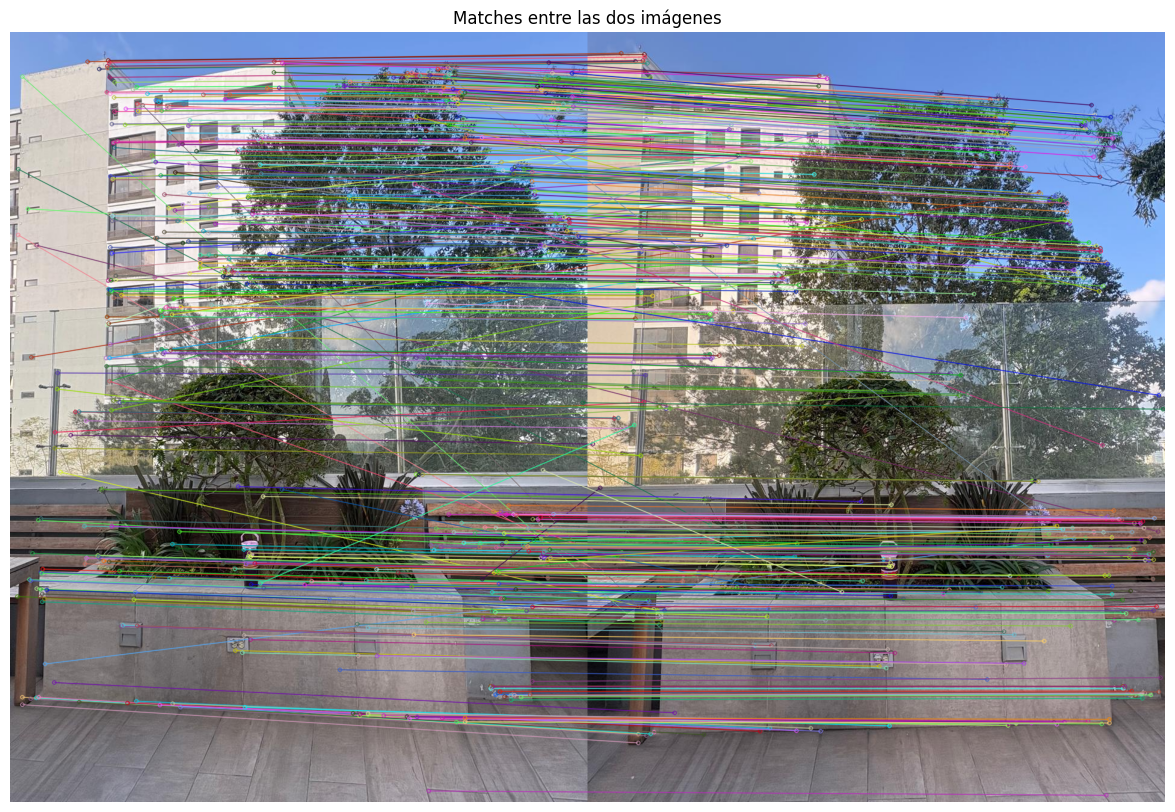

In [5]:
# SIFT y matching FLANN
sift = cv2.SIFT_create()
kp_left, des_left = sift.detectAndCompute(gray_left, None)  # Train (destino)
kp_right, des_right = sift.detectAndCompute(gray_right, None)  # Query (origen)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params, search_params)

# Derecha es query, izquierda es train
matches = flann.knnMatch(des_right, des_left, k=2)
# print(matches)
# print(len(matches))

good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)

print(f"Good matches encontrados: {len(good_matches)}")

img_matches = cv2.drawMatches(img_right, kp_right, img_left, kp_left, good_matches, None, flags=2)
plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.title('Matches entre las dos imágenes')
plt.axis('off')

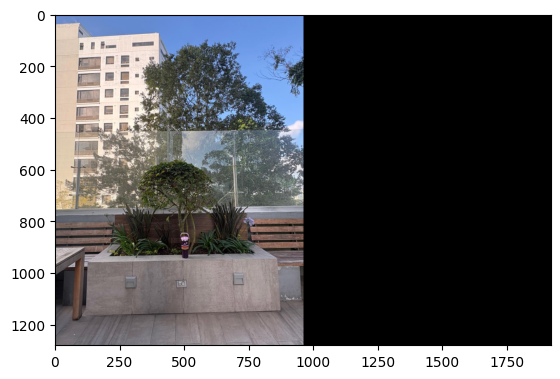

In [6]:
# Homografía

# Extraer coordenadas de los x, y
src_pts = np.float32([kp_right[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp_left[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# RANSAC
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# Warp * deformación y cálculo del canvas
h_left, w_left = img_left.shape[:2]
h_right, w_right = img_right.shape[:2]


#Ancho de  la imagen 1 + el ancho de la imagen 2  (Ancho = i1.w + i2.w)
# alto = de la imagen de imagen más alto
canvas_w = w_left + w_right
canvas_h = max(h_left, h_right)


panorama = cv2.warpPerspective(img_right, M, (canvas_w, canvas_h))
panorama[0:img_left.shape[0], 0:img_left.shape[1]] = img_left

dst_rgb = cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB)
plt.imshow(dst_rgb)
plt.show()

(-0.5, 959.5, 1279.5, -0.5)

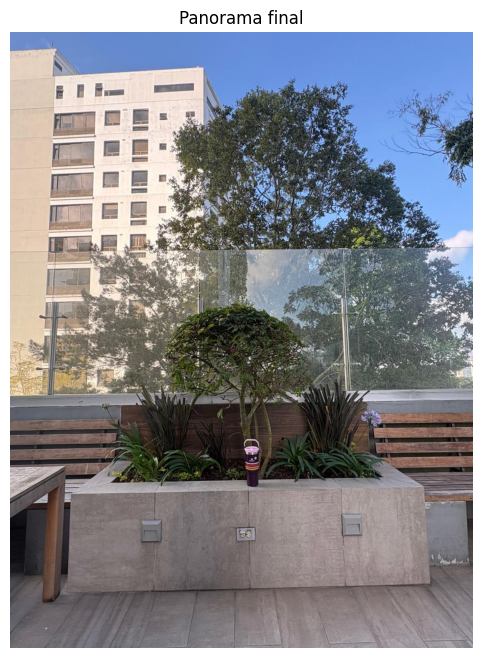

In [7]:
# Refinamiento del panorama (recorte del área útil)
panorama_gray = cv2.cvtColor(panorama, cv2.COLOR_BGR2GRAY)
_, mask_content = cv2.threshold(panorama_gray, 1, 255, cv2.THRESH_BINARY)

mask_inv = cv2.bitwise_not(mask_content)

left_on_canvas = np.zeros_like(panorama)
left_on_canvas[0:h_left, 0:w_left] = img_left

img_left_part = cv2.bitwise_and(left_on_canvas, left_on_canvas, mask=mask_inv)
panorama_part = cv2.bitwise_and(panorama, panorama, mask=mask_content)

result = cv2.add(img_left_part, panorama_part)

rows, cols = np.where(result[:, :, 0] != 0)
if len(cols) > 0:
    max_col = np.max(cols)
    result = result[:, :max_col + 1]

plt.figure(figsize=(15, 8))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title('Panorama final')
plt.axis('off')

## **Task 2**

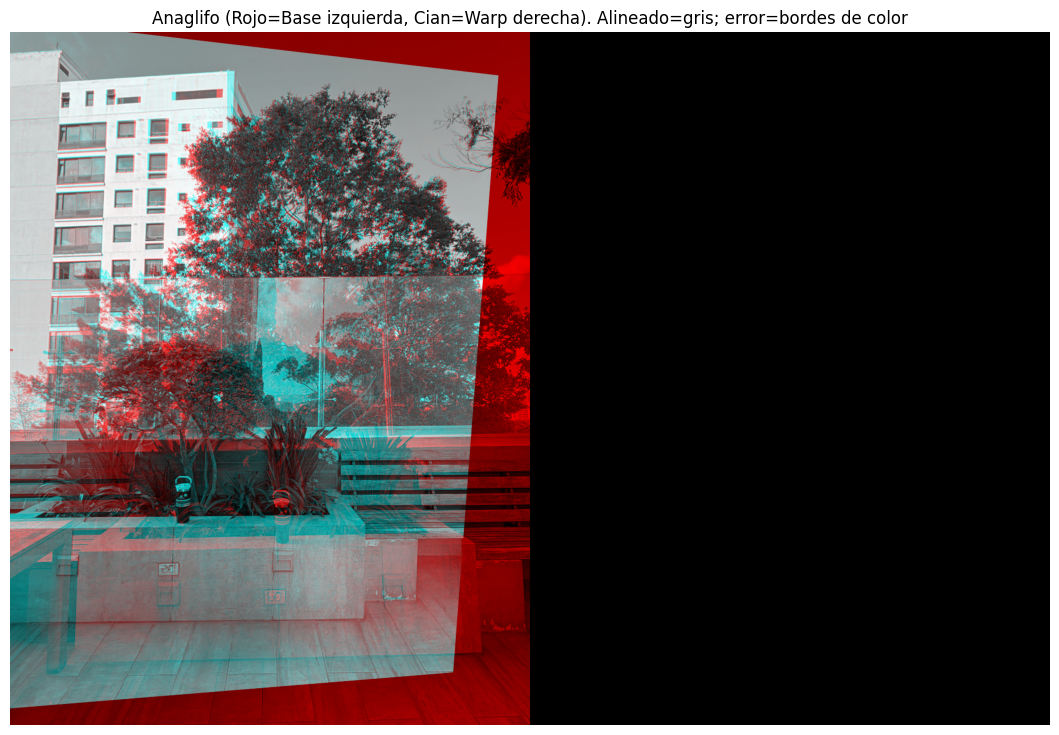

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- 1) Warp de la imagen derecha al canvas ---
h_left, w_left = img_left.shape[:2]
h_right, w_right = img_right.shape[:2]

canvas_w = w_left + w_right
canvas_h = max(h_left, h_right)

warped_right = cv2.warpPerspective(img_right, M, (canvas_w, canvas_h))

# Poner la izquierda en el canvas también
left_canvas = np.zeros((canvas_h, canvas_w, 3), dtype=np.uint8)
left_canvas[0:h_left, 0:w_left] = img_left

# --- 2) Crear máscaras de contenido (para no mezclar zonas negras vacías) ---
mask_warp = cv2.warpPerspective(np.ones((h_right, w_right), dtype=np.uint8)*255, M, (canvas_w, canvas_h))
mask_left = np.zeros((canvas_h, canvas_w), dtype=np.uint8)
mask_left[0:h_left, 0:w_left] = 255

# --- 3) Convertir a gris y construir anaglifo: R=base, G=B=warped ---
gray_left = cv2.cvtColor(left_canvas, cv2.COLOR_BGR2GRAY)
gray_warp = cv2.cvtColor(warped_right, cv2.COLOR_BGR2GRAY)

# Normalizar a 0..255 (uint8) por seguridad
gray_left_u8 = cv2.normalize(gray_left, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
gray_warp_u8 = cv2.normalize(gray_warp, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

anaglyph = np.zeros((canvas_h, canvas_w, 3), dtype=np.uint8)

# Canal Rojo = izquierda (solo donde hay izquierda)
anaglyph[..., 0] = 0  # (esto sería Azul en BGR, lo corregimos abajo con RGB)
anaglyph[..., 1] = 0
anaglyph[..., 2] = 0

# Construimos en RGB directamente para mostrar con matplotlib
anaglyph_rgb = np.zeros((canvas_h, canvas_w, 3), dtype=np.uint8)

# R
anaglyph_rgb[..., 0] = gray_left_u8 * (mask_left > 0)

# G y B (cian)
anaglyph_rgb[..., 1] = gray_warp_u8 * (mask_warp > 0)
anaglyph_rgb[..., 2] = gray_warp_u8 * (mask_warp > 0)

plt.figure(figsize=(16, 9))
plt.imshow(anaglyph_rgb)
plt.title("Anaglifo (Rojo=Base izquierda, Cian=Warp derecha). Alineado=gris; error=bordes de color")
plt.axis("off")
plt.show()

In [ ]:
## No nos salio lo de hacerlo en el notebook entonces se hizo el archivo Error.py

## No nos salio lo de hacerlo en el notebook enetonces se hizo en el archivo Error.py

Este es el codigo pero no hay neceisdad de correrlo:

```python
import numpy as np
import matplotlib.pyplot as plt


plt.figure(figsize=(16, 9))
plt.imshow(anaglyph_rgb)
plt.title(
    "TASK 2.2: Harás 6 clicks:\n"
    "1-2: A (Cercano) rojo->cian | 3-4: B (Medio) rojo->cian | 5-6: C (Fondo) rojo->cian\n"
    "Usa zoom para precisión."
)
plt.axis("off")
pts = plt.ginput(6, timeout=0)
plt.close()

def disparidad_x(p_rojo, p_cian):
    return abs(p_rojo[0] - p_cian[0])

A1, A2, B1, B2, C1, C2 = pts

filas = [
    ("A (Cercano)", A1, A2, disparidad_x(A1, A2)),
    ("B (Medio)",   B1, B2, disparidad_x(B1, B2)),
    ("C (Fondo)",   C1, C2, disparidad_x(C1, C2)),
]

print("{:<12} {:>9} {:>9} {:>9} {:>9} {:>14}".format("Objeto","x1","y1","x2","y2","|x1-x2| (px)"))
print("-"*70)
for nombre, p1, p2, d in filas:
    print("{:<12} {:>9.2f} {:>9.2f} {:>9.2f} {:>9.2f} {:>14.2f}".format(
        nombre, p1[0], p1[1], p2[0], p2[1], d
    ))
```

In [ ]:
import pandas as pd

# Estos datos los saque de Error.py, no salio usarlo en el notebook.

data = [
    ["A (Cercano)", 498.85, 869.73, 318.91, 838.36, 179.94],
    ["B (Medio)",   655.67, 909.35, 853.77, 942.36, 198.09],
    ["C (Fondo)",   294.15, 988.58, 488.94, 1041.41, 194.79],
]

df = pd.DataFrame(data, columns=[
    "Objeto", "x1", "y1", "x2", "y2", "|x1-x2| (px)"
])

df

,Objeto,x1,y1,x2,y2,|x1-x2| (px)
0,A (Cercano),498.85,869.73,318.91,838.36,179.94
1,B (Medio),655.67,909.35,853.77,942.36,198.09
2,C (Fondo),294.15,988.58,488.94,1041.41,194.79


## **Task 3**